# Signate開始時のお約束

In [669]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [670]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [671]:
!pip install signate

In [672]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [673]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [674]:
!pip install kanjize

In [675]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [676]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [677]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

<ipython-input-677-766871c38253>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

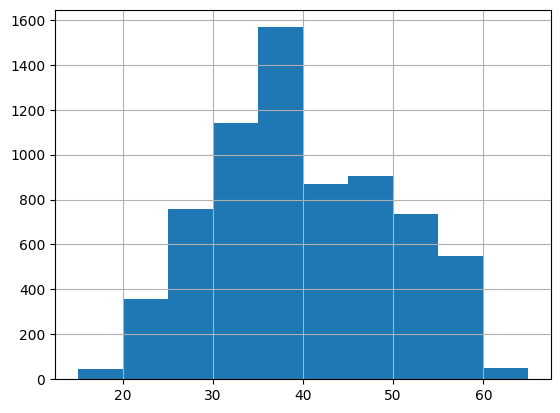

In [678]:
all_df["Age"].hist()

In [679]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

In [680]:
# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [681]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


In [682]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

<Axes: >

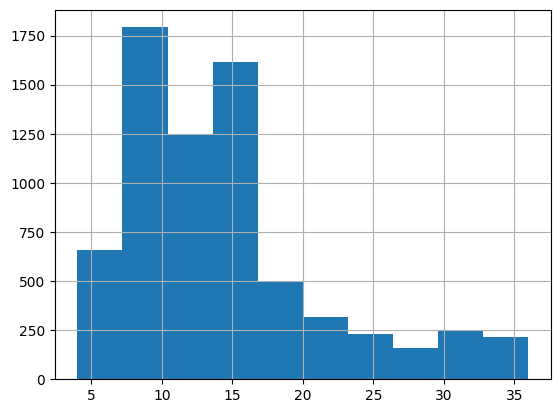

In [683]:
# 分布の確認
all_df["DurationOfPitch"].hist()

In [684]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [685]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"

  else:
    all_df.loc[i,"Gender"] = "Female"

In [686]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [687]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [688]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

In [689]:
# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [690]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [691]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

In [692]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [693]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"
    # all_df.loc[i,"ProductPitched"] = 1

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"
    # all_df.loc[i,"ProductPitched"] = 2

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"
    # all_df.loc[i,"ProductPitched"] = 3

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"
    # all_df.loc[i,"ProductPitched"] = 4

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"
    # all_df.loc[i,"ProductPitched"] = 5

  else:
    others.append(i)

In [694]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [695]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [696]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

<Axes: >

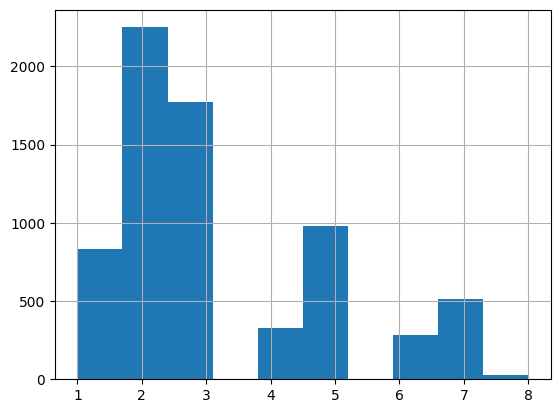

In [697]:
# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [698]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

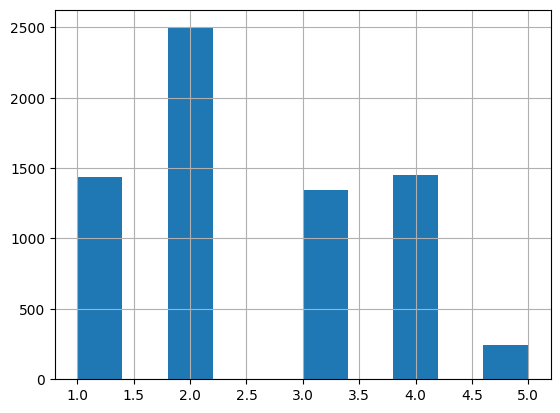

In [699]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [700]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [701]:
# Executive: 取締役、執行役員
# VP: 副社長、本部長
# AVP: 副社長補佐
# Senior Manager: 課長、次長
# Manager: 課長
# col = []

# for i in range(max_row):

#   if(all_df.loc[i,"Designation"] not in col):
#     col.append(all_df.loc[i,"Designation"])

In [702]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [703]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"
    # all_df.loc[i,"Designation"] = 5

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"
    # all_df.loc[i,"Designation"] = 4

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"
    # all_df.loc[i,"Designation"] = 3

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"
    # all_df.loc[i,"Designation"] = 2

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"
    # all_df.loc[i,"Designation"] = 1

In [704]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


In [705]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

<Axes: >

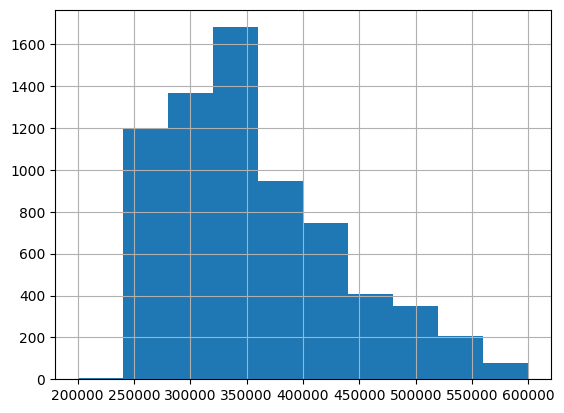

In [706]:
# 分布の確認
all_df["MonthlyIncome"].hist()

In [707]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [708]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [709]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [710]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [711]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


# 特徴量エンジニアリング

In [712]:
####################
# 新たな特徴を追加 #
####################
# 1. all_df["Age_times_Income"] = all_df["Age"] * all_df["MonthlyIncome"]
# 2. all_df["Income_times_Tier"] = all_df["MonthlyIncome"] * all_df["CityTier"]
# 3. all_df["Desig_times_Income"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]
# 4. all_df["Occu_times_Car"] = all_df["Occupation"] * all_df["CarHolder"]
# 5. all_df["Occu_times_DurPitch"] = all_df["Occupation_LE"] * all_df["DurationOfPitch"]
# 6. all_df["Gen_times_ProPitch"] = all_df["Gender_LE"] * all_df["ProductPitched_LE"]
# 7. all_df["Married_times_NumChild"] = all_df["Married_LE"] * all_df["NumofChild"]
# 8. all_df["Married_times_NumFollow"] = all_df["Married_LE"] * all_df["NumberOfFollowups"]
# 9. all_df["NumTrips_times_PropStar"] = all_df["NumberOfTrips"] * all_df["PreferredPropertyStar"]
# 10. all_df["Pass_times_Tier"] = all_df["Passport"] * all_df["CityTier"]
# 11. all_df["PropStar_times_Satisfac"] = all_df["PreferredPropertyStar"] * all_df["PitchSatisfactionScore"]
# 12. all_df["ProPitch_times_Trip"] = all_df["ProductPitched"] * all_df["NumberOfTrips"]
# 13. all_df["Contact_times_NumFollow"] = all_df["TypeofContact_LE"] * all_df["NumberOfFollowups"]
# 14. all_df["DurPitch_times_Satisfac"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]
# 15. all_df["Contact_times_Age"] = all_df["TypeofContact_LE"] * all_df["Age"]
# 16. all_df["Income_times_Tier_by_Trip"] = all_df["MonthlyIncome"] / all_df["CityTier"] * all_df["NumberOfTrips"]
# 17. all_df["Age_times_Satisfac_times_NumFollow"] = all_df["Age"] * all_df["PitchSatisfactionScore"] * all_df["NumberOfFollowups"]
# 18. all_df["NumChild_times_PropStar"] = all_df["NumofChild"] * all_df["PreferredPropertyStar"]

In [713]:
from sklearn.preprocessing import OrdinalEncoder
oe = preprocessing.OrdinalEncoder()

# all_df["Designation_LE"] = oe.fit_transform(all_df["Designation"].values.reshape(-1,1))
# all_df["Occupation_LE"] = oe.fit_transform(all_df["Occupation"].values.reshape(-1,1))
# all_df["Gender_LE"] = oe.fit_transform(all_df["Gender"].values.reshape(-1,1))
# all_df["ProductPitched_LE"] = oe.fit_transform(all_df["ProductPitched"].values.reshape(-1,1))
# all_df["Married_LE"] = oe.fit_transform(all_df["Married"].values.reshape(-1,1))
# all_df["TypeofContact_LE"] = oe.fit_transform(all_df["TypeofContact"].values.reshape(-1,1))

#------------------------------------------------------------------------------------
# 「Dsignation」をラベルエンコード
all_df["Designation_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Designation"]
  if(term=="Executive"):
    all_df.loc[i,"Designation_LE"] = 5
  elif(term=="VP"):
    all_df.loc[i,"Designation_LE"] = 4
  elif(term=="AVP"):
    all_df.loc[i,"Designation_LE"] = 3
  elif(term=="Senior Manager"):
    all_df.loc[i,"Designation_LE"] = 2
  elif(term=="Manager"):
    all_df.loc[i,"Designation_LE"] = 1

#------------------------------------------------------------------------------------
# 「Occupation」をラベルエンコード
all_df["Occupation_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Occupation"]
  if(term=="Large Business"):
    all_df.loc[i,"Occupation_LE"] = 3
  elif(term=="Small Business"):
    all_df.loc[i,"Occupation_LE"] = 2
  elif(term=="Salaried"):
    all_df.loc[i,"Occupation_LE"] = 1

# 「CarHolder」をラベルエンコード
all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

#------------------------------------------------------------------------------------
# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Gender"]
  if(term=="Female"):
    all_df.loc[i,"Gender_LE"] = 2
  elif(term=="Male"):
    all_df.loc[i,"Gender_LE"] = 1

# 「ProductPitched」をラベルエンコード
all_df["ProductPitched_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"ProductPitched"]
  if(term=="King"):
    all_df.loc[i,"ProductPitched_LE"] = 5
  elif(term=="SuperDeluxe"):
    all_df.loc[i,"ProductPitched_LE"] = 4
  elif(term=="Deluxe"):
    all_df.loc[i,"ProductPitched_LE"] = 3
  elif(term=="Standard"):
    all_df.loc[i,"ProductPitched_LE"] = 2
  elif(term=="Basic"):
    all_df.loc[i,"ProductPitched_LE"] = 1

#------------------------------------------------------------------------------------
# 「Married」をラベルエンコード
all_df["Married_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Married"]
  if(term=="Married"):
    all_df.loc[i,"Married_LE"] = 3
  elif(term=="Divorce"):
    all_df.loc[i,"Married_LE"] = 2
  elif(term=="Single"):
    all_df.loc[i,"Married_LE"] = 1

# 「TypeofContact」をラベルエンコード-----------------------------
all_df["TypeofContact_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"TypeofContact"]
  if(term=="Company Invited"):
    all_df.loc[i,"TypeofContact_LE"] = 2
  elif(term=="Self Enquiry"):
    all_df.loc[i,"TypeofContact_LE"] = 1
#-----------------------------------------------------------------

# 1.「Age」×「MonthlyIncome」 (若年高収入 or 高齢低収入)
all_df["Age_times_Income"] = all_df["Age"] * all_df["MonthlyIncome"]

# 2.「MonthlyIncome」×「CityTier」 (地域と収入のミスマッチ度)
all_df["Income_times_Tier"] = all_df["MonthlyIncome"] * all_df["CityTier"]

# 3.「Designation」×「MonthlyIncome」 (実際の報酬と役職の一致度(過小/過大評価)
all_df["Desig_times_Income"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]

# 4.「Occupation」×「CarHolder」 (経済属性の組み合わせ)
all_df["Occu_times_Car"] = all_df["Occupation"] * all_df["CarHolder"]

# 5.「Occupation」×「DurationOfPitch」 (ターゲット層ごとの営業効果の違い)
all_df["Occu_times_DurPitch"] = all_df["Occupation_LE"] * all_df["DurationOfPitch"]

# 6.「Gender」×「ProductPitched」 (商品嗜好の違いを反映)
all_df["Gen_times_ProPitch"] = all_df["Gender_LE"] * all_df["ProductPitched_LE"]

# 7.「Married」×「NumofChild」 (家庭環境の圧縮表現)
all_df["Married_times_NumChild"] = all_df["Married_LE"] * all_df["NumofChild"]

# 8.「Married」×「NumberOfFollowups」 (家族持ち層のフォロー行動の傾向分析)
all_df["Married_times_NumFollow"] = all_df["Married_LE"] * all_df["NumberOfFollowups"]

# 9.「NumberOfTrips」×「PreferredPropertyStar」 (旅行慣れ層の嗜好)
all_df["NumTrips_times_PropStar"] = all_df["NumberOfTrips"] * all_df["PreferredPropertyStar"]

# 10.「Passport」×「CitytTier」 (国際経験と居住地との関係性)
all_df["Pass_times_Tier"] = all_df["Passport"] * all_df["CityTier"]

# 11.「PrefferedPropertyStar」×「PitchSatisfactionScore」 (高級志向と満足度の関係性)
all_df["PropStar_times_Satisfac"] = all_df["PreferredPropertyStar"] * all_df["PitchSatisfactionScore"]

# 12.「ProductPitched」×「NumberOfTrips」 (リピーターに対する商品設計の効き方)
all_df["ProPitch_times_Trip"] = all_df["ProductPitched"] * all_df["NumberOfTrips"]

# 13.「TypeofContact」×「NumberOfFollowups」 (コンタクトチャネルの最適性分析)
all_df["Contact_times_NumFollow"] = all_df["TypeofContact_LE"] * all_df["NumberOfFollowups"]

# 14.「DurationPitched」×「PitchSatisfactionScore」 (営業時間と結果の相関分析)
all_df["DurPitch_times_Satisfac"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]

# 15.「TypeofContact」×「Age」 (高齢層に対する適切なチャネル分析)
all_df["Contact_times_Age"] = all_df["TypeofContact_LE"] * all_df["Age"]

# 16.(「MonthlyIncome」 ÷ 「CityTier」) × NumberOfTrips = 地域あたり可処分所得の旅行傾向
all_df["Income_times_Tier_by_Trip"] = all_df["MonthlyIncome"] / all_df["CityTier"] * all_df["NumberOfTrips"]

# 17.「Age」×「PitchSatisfactionScore」×「NumberOfFollowups」 = 長期的関係性の影響
all_df["Age_times_Satisfac_times_NumFollow"] = all_df["Age"] * all_df["PitchSatisfactionScore"] * all_df["NumberOfFollowups"]

# 18.「NumofChild」×「PreferredPropertyStar」 = 家族連れの高級志向傾向の抽出
all_df["NumChild_times_PropStar"] = all_df["NumofChild"] * all_df["PreferredPropertyStar"]

In [714]:
# 使用済みのラベルは抹消する
all_df = all_df.drop("Designation_LE", axis=1)
all_df = all_df.drop("Occupation_LE", axis=1)
all_df = all_df.drop("Gender_LE", axis=1)
all_df = all_df.drop("ProductPitched_LE", axis=1)
all_df = all_df.drop("Married_LE", axis=1)
all_df = all_df.drop("TypeofContact_LE", axis=1)

In [715]:
# 1. all_df["Age_times_Income"] = all_df["Age"] * all_df["MonthlyIncome"]
# 2. all_df["Income_times_Tier"] = all_df["MonthlyIncome"] * all_df["CityTier"]
# 3. all_df["Desig_times_Income"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]
# 4. all_df["Occu_times_Car"] = all_df["Occupation"] * all_df["CarHolder"]
# 5. all_df["Occu_times_DurPitch"] = all_df["Occupation_LE"] * all_df["DurationOfPitch"]
# 6. all_df["Gen_times_ProPitch"] = all_df["Gender_LE"] * all_df["ProductPitched_LE"]
# 7. all_df["Married_times_NumChild"] = all_df["Married_LE"] * all_df["NumofChild"]
# 8. all_df["Married_times_NumFollow"] = all_df["Married_LE"] * all_df["NumberOfFollowups"]
# 9. all_df["NumTrips_times_PropStar"] = all_df["NumberOfTrips"] * all_df["PreferredPropertyStar"]
# 10. all_df["Pass_times_Tier"] = all_df["Passport"] * all_df["CityTier"]
# 11. all_df["PropStar_times_Satisfac"] = all_df["PreferredPropertyStar"] * all_df["PitchSatisfactionScore"]
# 12. all_df["ProPitch_times_Trip"] = all_df["ProductPitched"] * all_df["NumberOfTrips"]
# 13. all_df["Contact_times_NumFollow"] = all_df["TypeofContact_LE"] * all_df["NumberOfFollowups"]
# 14. all_df["DurPitch_times_Satisfac"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]
# 15. all_df["Contact_times_Age"] = all_df["TypeofContact_LE"] * all_df["Age"]
# 16. all_df["Income_times_Tier_by_Trip"] = all_df["MonthlyIncome"] / all_df["CityTier"] * all_df["NumberOfTrips"]
# 17. all_df["Age_times_Satisfac_times_NumFollow"] = all_df["Age"] * all_df["PitchSatisfactionScore"] * all_df["NumberOfFollowups"]
# 18. all_df["NumChild_times_PropStar"] = all_df["NumofChild"] * all_df["PreferredPropertyStar"]

In [716]:
# 取り除く変数
RMV = ["id","ProdTaken"]

# 使用する変数を制限
FEATURES = ["Age","TypeofContact","CityTier","DurationOfPitch","Occupation","Gender","NumberOfPersonVisiting","NumberOfFollowups","ProductPitched",
            "PreferredPropertyStar","NumberOfTrips","Passport","PitchSatisfactionScore","MonthlyIncome","CarHolder","Married","NumofChild","Designation",
            "Age_times_Income","Income_times_Tier","Desig_times_Income","Occu_times_Car","Occu_times_DurPitch","Gen_times_ProPitch",
            "Married_times_NumChild","Married_times_NumFollow","NumTrips_times_PropStar","Pass_times_Tier","PropStar_times_Satisfac",
            "ProPitch_times_Trip","Contact_times_NumFollow","DurPitch_times_Satisfac","Contact_times_Age","Income_times_Tier_by_Trip",
            "Age_times_Satisfac_times_NumFollow","NumChild_times_PropStar",
            "ProdTaken"]
            # "ProdTaken","AveProdTaken_numChild"]

TARGET = "ProdTaken"

In [717]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [718]:
# カラムを制限
all_df2 = all_df[FEATURES]

In [719]:
from sklearn.preprocessing import OrdinalEncoder

oe = preprocessing.OrdinalEncoder()
all_df2[CATS] = oe.fit_transform(all_df2[CATS].values)

<ipython-input-719-2dd9a187d6f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df2[CATS] = oe.fit_transform(all_df2[CATS].values)


In [720]:
# one-hot
# all_df2 = pd.get_dummies(all_df2, columns=CATS)

In [721]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

In [722]:
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)

In [723]:
FEATURES = test.columns

In [740]:
# import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
# from xgboost import XGBRegressor, XGBClassifier
# import xgboost
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7310002414300506, # 7回
    'num_leaves': 9, # 20回
    'bagging_fraction': 0.46766930795838424,
    # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
    'lambda_l1': 2.5822011957418005,
    'lambda_l2': 7.210420837783116,
    'min_data_in_leaf': 47,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [741]:
%%time

FOLDS = 3 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.922832	valid's auc: 0.838442
#########################
### Fold 2
#########################
[100]	train's auc: 0.933766	valid's auc: 0.810943
#########################
### Fold 3
#########################
[100]	train's auc: 0.927465	valid's auc: 0.836657
CPU times: user 2.39 s, sys: 241 ms, total: 2.63 s
Wall time: 608 ms


In [742]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8282415078707539


In [743]:
# importanceを表示する
importance = pd.DataFrame(models[1].feature_importance(importance_type="gain"),
                          index=test.columns,columns=['importance'])
importance = importance.sort_values("importance", ascending=False)
display(importance)

,importance
ProductPitched,79.489784
Age_times_Income,68.694985
Gen_times_ProPitch,53.896094
Married,47.439209
MonthlyIncome,40.609757
Desig_times_Income,24.896628
Pass_times_Tier,18.743769
Passport,17.846907
Age,13.830989
Income_times_Tier,12.456656


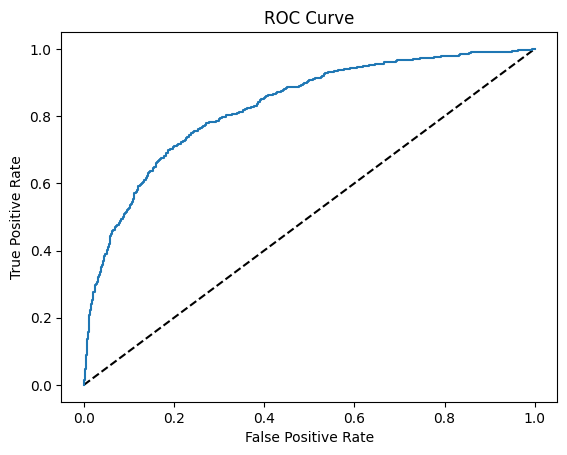

In [728]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [729]:
!pip install optuna

In [730]:
# # Optunaを使用する
# import optuna
# import lightgbm as lgb
# from sklearn.datasets import load_diabetes
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# import numpy as np
# from sklearn.model_selection import KFold # K分割
# import lightgbm as lgb
# from lightgbm import LGBMRegressor, LGBMClassifier
# from sklearn.metrics import mean_squared_error

# def objective(trial):

#   lgbm_params = {
#       'objective': 'regression',
#       "device": "cpu",
#       'metric': 'rmse',
#       'verbose': -1,              # ログ出力の制御
#       'boosting_type': 'gbdt',
#       'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
#       'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
#       'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
#       # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
#       'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
#       'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
#       'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
#       'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
#       # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
#       # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
#       # 'max_depth': trial.suggest_int('max_depth', 3, 12),
#       }

#   FOLDS = 3 # 分割数
#   kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

#   oof_lgb = np.zeros(len(train))
#   pred_lgb = np.zeros(len(test))
#   models = []
#   evaluations_result = {}

#   for i, (train_index, test_index) in enumerate(kf.split(train)):

#     print("#"*25)
#     print(f"### Fold {i+1}")
#     print("#"*25)

#     # インデックスに割り振る

#     x_train = train.loc[train_index, FEATURES].copy()
#     y_train = train.loc[train_index, TARGET]
#     x_valid = train.loc[test_index, FEATURES].copy()
#     y_valid = train.loc[test_index, TARGET]
#     # x_test = test[FEATURES].copy()

#     # データセット作成
#     lgb_train = lgb.Dataset(x_train, y_train)
#     lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

#     # 学習
#     model_lgb = lgb.train(lgbm_params,
#                           lgb_train,
#                           num_boost_round = 2000,
#                           valid_sets = [lgb_train, lgb_eval],
#                           valid_names = ["train", "valid"],
#                           callbacks = [
#                               lgb.early_stopping(stopping_rounds=100, verbose=False),
#                               # lgb.record_evaluation(evaluations_result),
#                               lgb.log_evaluation(100),])


#     # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

#     oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
#     # models.append(model_lgb)
#     # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

#   # pred_lgb = []
#   # # 予測
#   # for model in models:
#   #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

#   # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

#   # pred_lgb /= FOLDS
#   # score = roc_auc_score(train[TARGET],oof_lgb)

#   mse = mean_squared_error(train[TARGET], oof_lgb)
#   rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算

#   return rmse

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)

In [731]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.503330921326445, 'num_leaves': 7, 'bagging_fraction': 0.6326776172399775, 'lambda_l1': 3.952264683012362, 'lambda_l2': 4.849256031364845, 'min_data_in_leaf': 19}
[0.3063010536376912]


In [732]:
lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    'metric': 'rmse',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7310002414300506, # 7回
    'num_leaves': 9, # 20回
    'bagging_fraction': 0.46766930795838424,
    # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
    'lambda_l1': 2.5822011957418005,
    'lambda_l2': 7.210420837783116,
    'min_data_in_leaf': 47,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [733]:
%%time

FOLDS = 3 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's rmse: 0.269578	valid's rmse: 0.301054
#########################
### Fold 2
#########################
[100]	train's rmse: 0.259206	valid's rmse: 0.326655
#########################
### Fold 3
#########################
[100]	train's rmse: 0.271094	valid's rmse: 0.292881
CPU times: user 2.27 s, sys: 11.9 ms, total: 2.28 s
Wall time: 293 ms


In [734]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8273265932493357


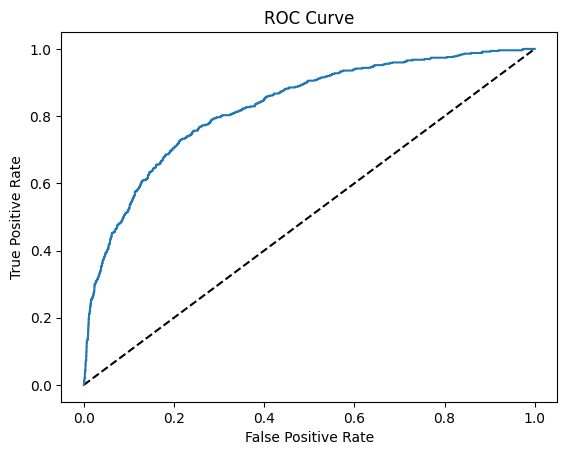

In [735]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [736]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [737]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [738]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)